In [36]:
# NUMPY
import numpy as np

# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# POT
import ot
from ot import sinkhorn, emd
# from ot.bregman import sinkhorn, greenkhorn

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 

# GREENKHORN 
# from greenkhorn.sinkhorn import sinkhorn as sinkhgreen
# SCREENKHORN
from screenkhorn.screenkhorn import Screenkhorn
# np.random.seed(3946)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data generation

In [37]:
n_1 = 200# nb samples
n_2 = 200
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 10.

K = np.exp(-M/reg)

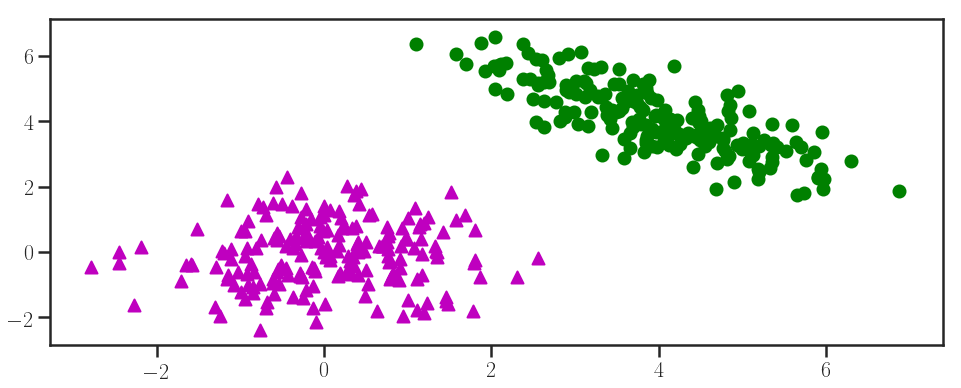

In [38]:
plt.scatter(xs[:,0], xs[:,1], marker='^', c='m')
plt.scatter(xt[:,0], xt[:,1], marker='o', c='g');

## Sinkhorn's algorithm from POT

In [39]:
P_sink = sinkhorn(a, b, M, reg, log=True)

# Print P^star, u_sink = e^{u^star}, v_sink = e^{v^star}
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']

## Plots of $e^{u^\star}$ and $e^{v^\star}$ 

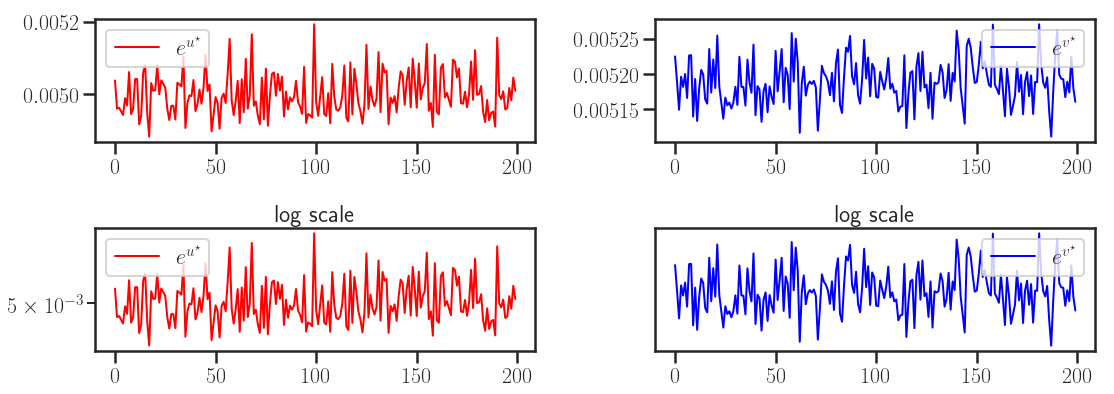

In [40]:
figure, axes= plt.subplots(nrows=2, ncols=2)

axes[0,0].plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
axes[0,1].plot(exp_v_star, linewidth=2, color='b', label=r'$e^{v^\star}$')
axes[0,0].legend()
axes[0,1].legend();

axes[1,0].semilogy(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
axes[1,1].semilogy(exp_v_star, linewidth=2, color='b', label=r'$e^{v^\star}$')
axes[1,0].legend()
axes[1,0].set_title("log scale")
axes[1,1].set_title("log scale")
axes[1,1].legend();
plt.subplots_adjust(hspace=.5)
plt.tight_layout()

### Plots of $u^\star$ and $v^\star$

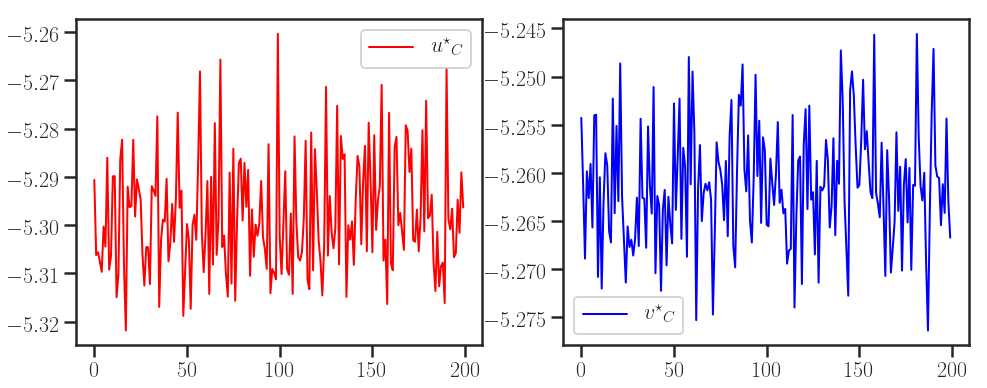

In [41]:
u_star = np.log(exp_u_star)
v_star = np.log(exp_v_star)

figure, axes= plt.subplots(ncols=2)
axes[0].plot(u_star, linewidth=2, color='r', label=r'${u^\star}_C$')
axes[1].plot(v_star, linewidth=2, color='b', label=r'${v^\star}_C$')
axes[0].legend()
axes[1].legend();

## Choosing of the intervals $I_u$ and $J_v$

In [42]:
epsilon = 0.0
I = np.where(exp_u_star >= epsilon)[0].tolist()
Ic = np.where(exp_u_star < epsilon)[0].tolist()
len(I), len(Ic)

(200, 0)

In [43]:
J = np.where(exp_v_star >= epsilon)[0].tolist()
Jc = np.where(exp_v_star < epsilon)[0].tolist()
len(J), len(Jc)

(200, 0)

# `screenkhorn`

In [44]:
screenkhorn = Screenkhorn(a, b, M, reg, epsilon)

## Projected Gradient Descent 

In [57]:
proj_grad_ord = \
screenkhorn.projected_grad(- np.ones(n_1), -np.ones(n_2), I, J, max_iter_backtracking=30,
                           step_size=100., max_iter=1000, tol=1e-10, verbose=False)

  2%|▏         | 20/1000 [00:00<00:19, 50.91it/s]

Achieved relative tolerance at iteration 30


### Curve of the objective function

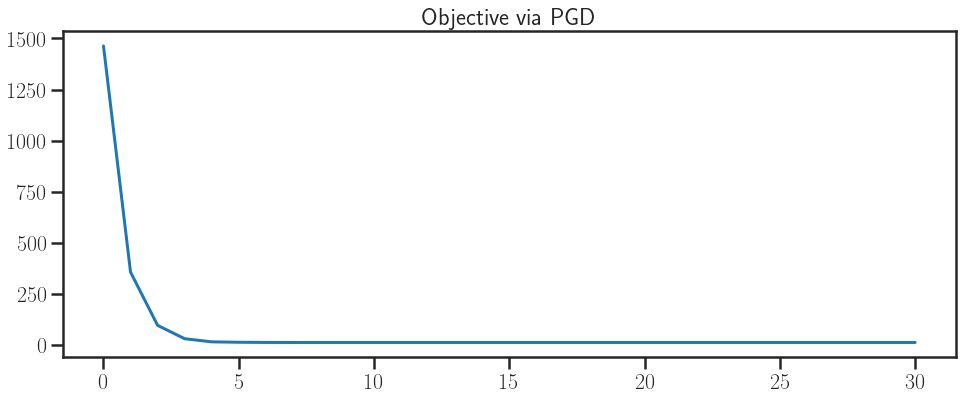

In [58]:
obj_ord = proj_grad_ord["trace_obj"]
plt.plot(obj_ord);
plt.title("Objective via PGD");

### Sort of the solution by `screenkhorn` 

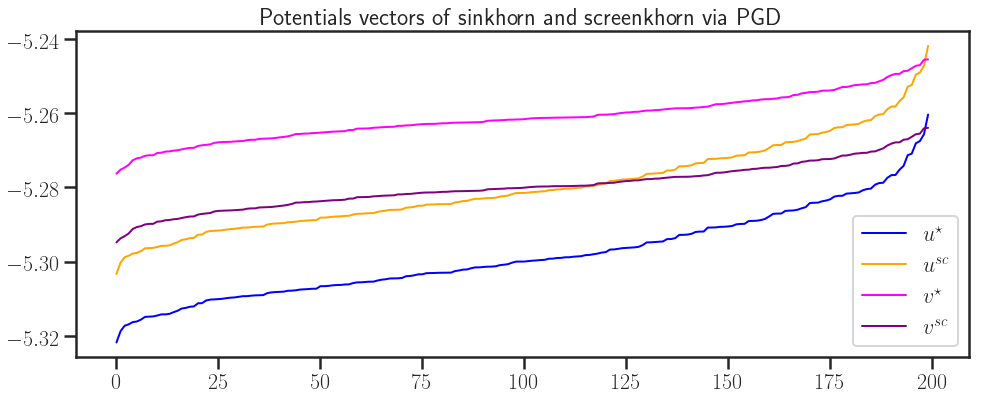

In [59]:
plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(proj_grad_ord["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(proj_grad_ord["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
plt.legend(loc='best');
plt.title(r'Potentials vectors of sinkhorn and screenkhorn via PGD');

### Checking the solutions of Block PDG

In [60]:
# sinkhorn
P_star = np.diag(np.exp(u_star)) @ K @ np.diag(np.exp(v_star)) 
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

# screenkhorn via pgd
usc_ord = proj_grad_ord["usc"]
vsc_ord = proj_grad_ord["vsc"]
P_sc_ord = np.diag(np.exp(usc_ord)) @ K @ np.diag(np.exp(vsc_ord))
a_sc_ord = P_sc_ord @ np.ones(n_2)
b_sc_ord = P_sc_ord.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_ord), sum(b_sc_ord)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_ord)), abs(1 - sum(b_sc_ord))))
print("\t")
print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(P_star - P_sc_ord,'fro'))
print('\t')
print("Max norm of difference solution matrices %s "  %abs(P_star - P_sc_ord).max())

sum of the marginals in sinkhorn are: 1.0000000000000007, 	 1.0000000000000002
	
sum of the marginals in screenkhorn are: 0.9999999999999999, 	 0.9999999999999999
	
Difference in sinkhorn: 6.661338147750939e-16 	 2.220446049250313e-16:
	
Difference in screenkhorn: 1.1102230246251565e-16 	  1.1102230246251565e-16:
	
Frobenius norm of difference solution matrices 5.358445585926475e-08 
	
Max norm of difference solution matrices 7.75023712362103e-10 


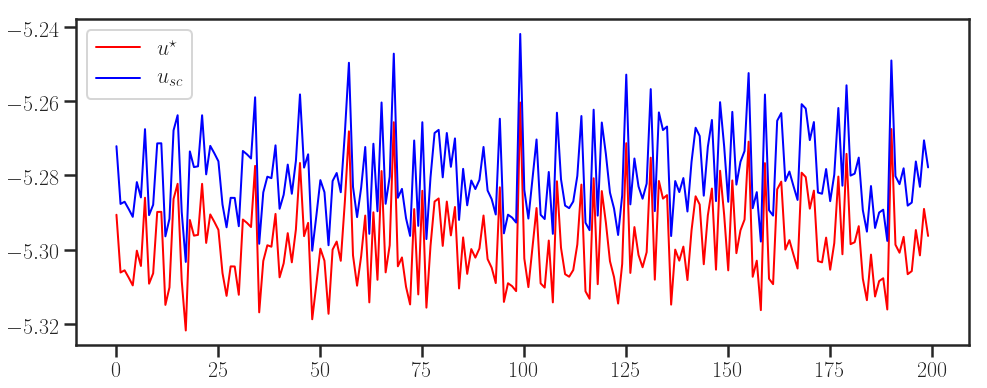

In [61]:
plt.plot(u_star, linewidth=2, color='r', label=r'${u^\star}$')
plt.plot(usc_ord, linewidth=2, color='b', label=r'$u_{sc}$')
plt.legend()
plt.legend();

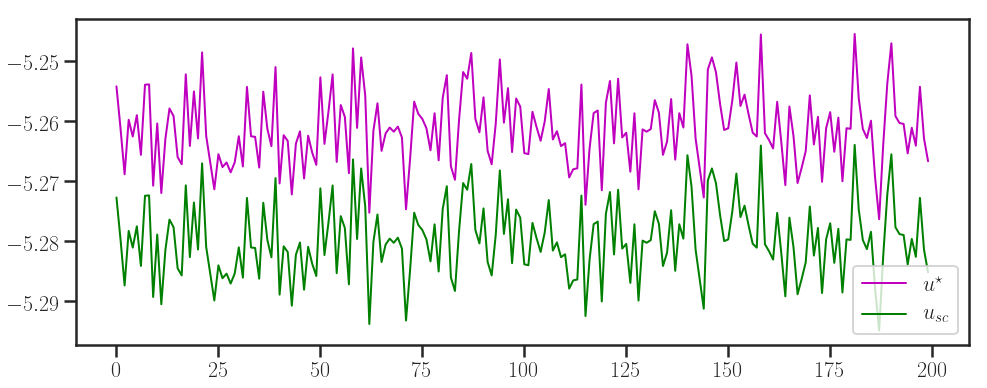

In [62]:
plt.plot(v_star, linewidth=2, color='m', label=r'${u^\star}$')
plt.plot(vsc_ord, linewidth=2, color='g', label=r'$u_{sc}$')
plt.legend()
plt.legend();

## Block Projected Gradient Decsent

In [71]:
proj_grad_alt = \
screenkhorn.block_projected_grad(-np.ones(n_1), -np.ones(n_2), I, J, max_iter_backtracking=30,
                                 step_size=100., max_iter=1000, tol=1e-10, verbose=False)

/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:335: RuntimeWarning: divide by zero encountered in log
  usc[Ic] = np.log(self.epsilon) * np.ones(len(Ic))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:336: RuntimeWarning: divide by zero encountered in log
  vsc[Jc] = np.log(self.epsilon) * np.ones(len(Jc))
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:138: RuntimeWarning: divide by zero encountered in log
  u_proj[np.where(u < np.log(self.epsilon))] = np.log(self.epsilon)
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:87: RuntimeWarning: divide by zero encountered in log
  u_param_Ic = np.log(self.epsilon) * np.ones(len(Ic))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:88: RuntimeWarning: divide by zero encountered in log
  v_param_Jc = np.log(self.epsilon) * np.ones(len(Jc))
100%|██████████| 100

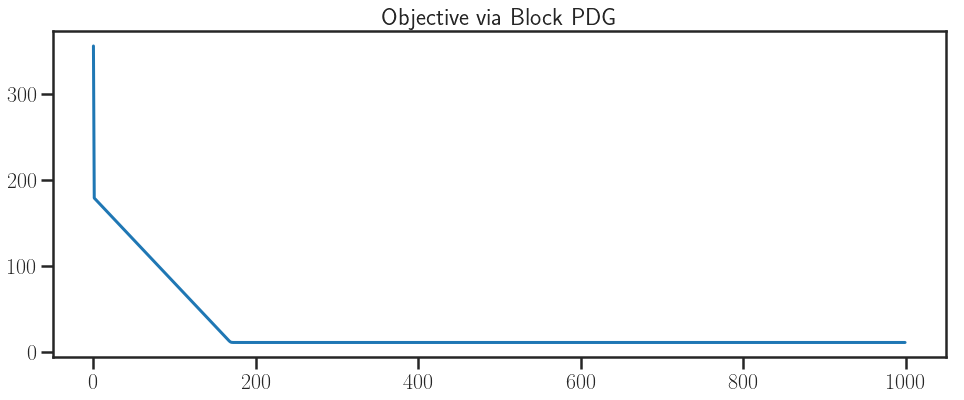

In [72]:
obj_alt= proj_grad_alt["trace_obj"]
plt.plot(obj_alt)
plt.title("Objective via Block PDG");

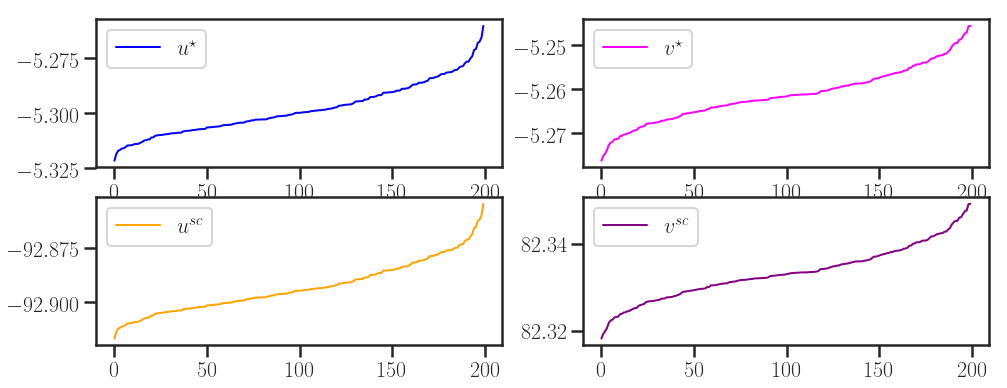

In [73]:
figure, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
axes[1,0].plot(np.sort(proj_grad_alt["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
axes[0,1].plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
axes[1,1].plot(np.sort(proj_grad_alt["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')

axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend();

# plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
# plt.plot(np.sort(proj_grad_alt["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
# plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
# plt.plot(np.sort(proj_grad_alt["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
# plt.legend(loc='best');
# plt.title(r'log-potentials vectors of sinkhorn and screenkhorn with ${maxIter}=10000,\,tol=1e-19$')
# plt.title(r'Potentials vectors of sinkhorn and screenkhorn via Block PGD');

### Checking the solutions of Block PDG

In [74]:
# screenkhorn via block pgd
usc_alt = proj_grad_alt["usc"]
vsc_alt = proj_grad_alt["vsc"]
P_sc_alt = np.diag(np.exp(usc_alt)) @ K @ np.diag(np.exp(vsc_alt))
a_sc_alt = P_sc_alt @ np.ones(n_2)
b_sc_alt  = P_sc_alt.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_alt), sum(b_sc_alt)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_alt)), abs(1 - sum(b_sc_alt))))

print("\t")
print("Frobenius norm of %s ",  np.linalg.norm(P_star - P_sc_alt,'fro'))
print('\t')
print("Max norm of %s ",  abs(P_star - P_sc_alt).max())

sum of the marginals in sinkhorn are: 1.0000000000000007, 	 1.0000000000000002
	
sum of the marginals in screenkhorn are: 1.000000000000001, 	 1.000000000000002
	
Difference in sinkhorn: 6.661338147750939e-16 	 2.220446049250313e-16:
	
Difference in screenkhorn: 1.1102230246251565e-15 	  1.9984014443252818e-15:
	
Frobenius norm of %s  5.3585261100490434e-08
	
Max norm of %s  7.750271157608139e-10


## Accelerated Projected Gradient Descent

In [75]:
proj_grad_acc = \
screenkhorn.accelerated_projected_grad(-np.ones(n_1), -np.ones(n_2), I, J, 
                                        max_iter_backtracking=70,
                                        step_size=100., max_iter=1000, tol=1e-10, verbose=False)

/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:443: RuntimeWarning: divide by zero encountered in log
  usc[Ic] = np.log(self.epsilon) * np.ones(len(Ic))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:444: RuntimeWarning: divide by zero encountered in log
  vsc[Jc] = np.log(self.epsilon) * np.ones(len(Jc))
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:138: RuntimeWarning: divide by zero encountered in log
  u_proj[np.where(u < np.log(self.epsilon))] = np.log(self.epsilon)
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:87: RuntimeWarning: divide by zero encountered in log
  u_param_Ic = np.log(self.epsilon) * np.ones(len(Ic))
/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:88: RuntimeWarning: divide by zero encountered in log
  v_param_Jc = np.log(self.epsilon) * np.ones(len(Jc))
  1%|          | 12/

Achieved relative tolerance at iteration 30


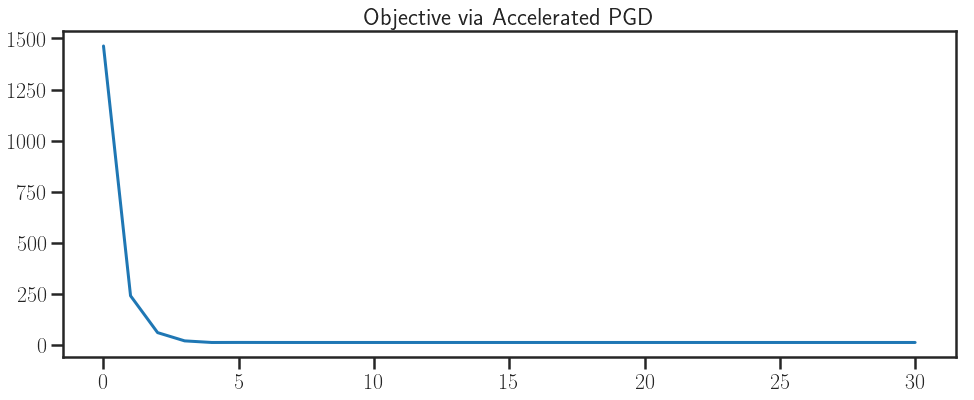

In [76]:
#plt.yscale("log")
obj_acc= proj_grad_acc["trace_obj"]
plt.plot(obj_acc)
plt.title("Objective via Accelerated PGD");

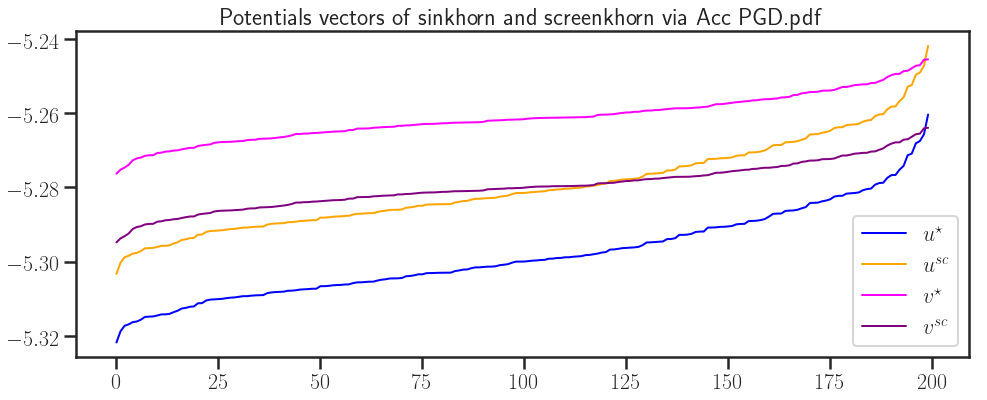

In [77]:
plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(proj_grad_acc["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(proj_grad_acc["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
plt.legend(loc='best');
# plt.title(r'log-potentials vectors of sinkhorn and screenkhorn with ${maxIter}=10000,\,tol=1e-19$')
plt.title(r'Potentials vectors of sinkhorn and screenkhorn via Acc PGD.pdf');

### Checking the solutions of Block PDG

In [78]:
# screenkhorn via pgd
usc_acc = proj_grad_acc["usc"]
vsc_acc = proj_grad_acc["vsc"]
P_sc_acc = np.diag(np.exp(usc_acc)) @ K @ np.diag(np.exp(vsc_acc))
a_sc_acc = P_sc_acc @ np.ones(n_2)
b_sc_acc  = P_sc_acc.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_acc), sum(b_sc_acc)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_acc)), abs(1 - sum(b_sc_acc))))

print("\t")
print("Frobenius norm of %s " %np.linalg.norm(P_star - P_sc_acc,'fro'))
print('\t')
print("Max norm of %s "  %abs(P_star - P_sc_acc).max())

sum of the marginals in sinkhorn are: 1.0000000000000007, 	 1.0000000000000002
	
sum of the marginals in screenkhorn are: 0.9999999999999996, 	 1.0000000000000007
	
Difference in sinkhorn: 6.661338147750939e-16 	 2.220446049250313e-16:
	
Difference in screenkhorn: 4.440892098500626e-16 	  6.661338147750939e-16:
	
Frobenius norm of 5.359087975328121e-08 
	
Max norm of 7.750536811399421e-10 


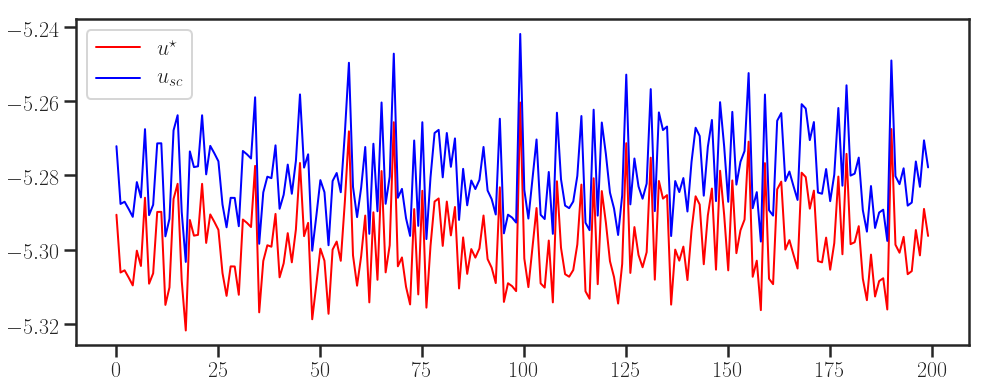

In [79]:
usc_alt = proj_grad_acc["usc"]
vsc_alt = proj_grad_acc["vsc"]

plt.plot(u_star, linewidth=2, color='r', label=r'${u^\star}$')
plt.plot(usc_acc, linewidth=2, color='b', label=r'$u_{sc}$')
plt.legend()
plt.legend();

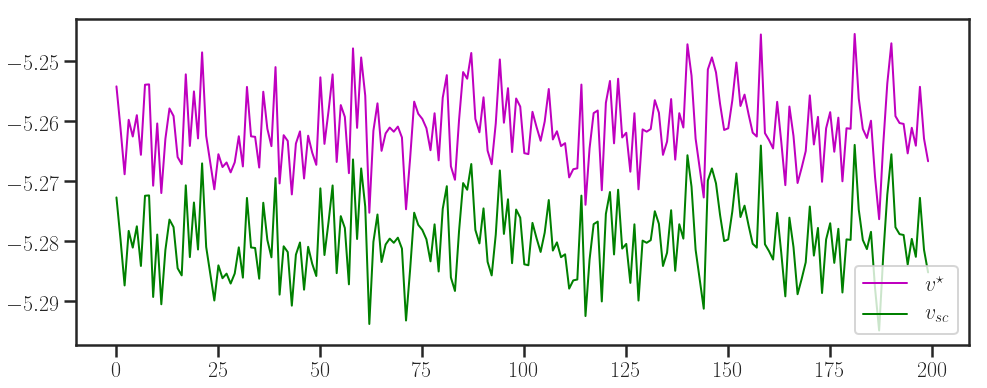

In [80]:
plt.plot(v_star, linewidth=2, color='m', label=r'${v^\star}$')
plt.plot(vsc_acc, linewidth=2, color='g', label=r'$v_{sc}$')
plt.legend()
plt.legend();